## Example with CNN-LSTM on live BTC close price using the full data

In [18]:
import subprocess
import sys
import warnings
import os
from IPython.display import display, HTML
os.environ["TZ"] = "UTC"
warnings.filterwarnings("ignore")

USE_COLAB = False
if USE_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = '/content/drive/MyDrive/Colab Notebooks/sats4u/'
    secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'    
else:
    work_dir = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/sats4u/'
    secret_data_folder = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/crypto_project/crypto_data/'
    
# if 'darwin' in sys.platform:
#     print('Running \'caffeinate\' on MacOSX to prevent the system from sleeping')
#     subprocess.Popen('caffeinate')

os.chdir(work_dir)
dir_to_save = '/Users/gabrieletocci/Documents/projects/CODE/data_sats4u/'

In [19]:
! pip install -r requirements.txt

In [20]:
import json
import pandas as pd
import numpy as np
from binance.enums import *
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b
import re

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)


## Load Asset Details, Binance client data and Download 15m candles from Binance

In [21]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details, data_folder,verbose=False)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)

In [22]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder,verbose = False)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

### Generate Candles and build features from technical analysis

In [23]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts(verbose=True)
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [24]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220709_08_45"

initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [25]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

183

,Close,Pred Close
Date,,
2022-05-20 17:00:00,28946.22,28854.223214
2022-05-20 17:15:00,28771.14,28871.325860
2022-05-20 17:30:00,28918.03,28929.628700
2022-05-20 17:45:00,28959.22,28802.385011
2022-05-20 18:00:00,28884.71,28856.373728
...,...,...
2022-07-11 05:30:00,20561.57,20482.099716
2022-07-11 05:45:00,20506.53,20486.754254
2022-07-11 06:00:00,20381.28,20532.284936


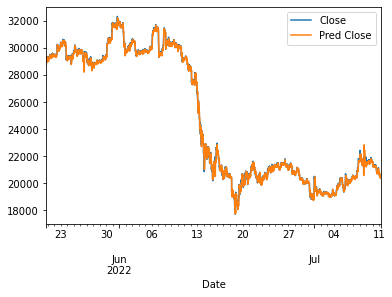

In [26]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period =  +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

In [29]:
new_time_steps
48*60/15

192.0

Initial time 2022-07-09 09:15:00
Final time 2022-07-11 06:30:00
Fee: 0.025
----------------------
Buy      14 ( 14 ok 0 ko )
Avg PCT gain: 1.0041719770649296
Avg PCT loss: 0
Wins  PCT   1.0
Avg PCT Gain.    1.0041719770649296
No-op    165
Wallet   1197.54375
Drawback 0
Kelly Fraction    nan
Total earned 1197.54375


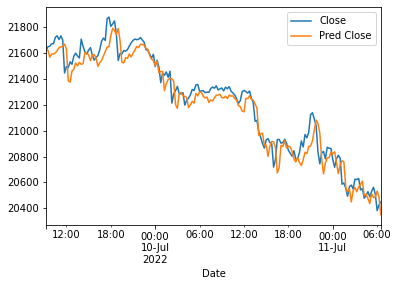

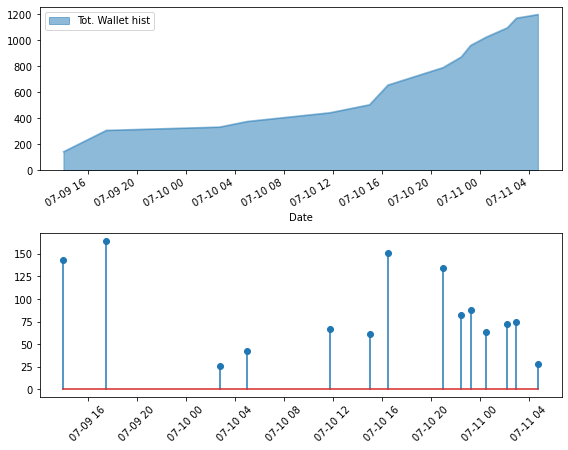

In [34]:
step_back_val = 2
if new_time_steps > step_back_val :
    df_preds_true.iloc[-new_time_steps:].dropna().plot()

    wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.iloc[-new_time_steps:].dropna(), step_back=+ 2,
                                                    long_short = "long", fee=0.025, cutoff_long =100. ,cutoff_short = 100.0)
    s2b.show_backtest_results(wallet,wallet_hist_df)

In [16]:
def tryexceptwait(func):
  def inner(*args,**kwargs):
        try:
          return func(*args, **kwargs)
        except:
          time.sleep(61)
          return func(*args,**kwargs)
  return inner

@tryexceptwait
def getminutedata(binance_client, ticker,interval, look_back):

  frame = pd.DataFrame(binance_client.get_historical_klines(ticker,interval, look_back + "min ago UTC"))
  frame = frame.iloc[:,:6]
  frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
  frame = frame.set_index("Time")
  frame.index = pd.to_datetime(frame.index,unit = "ms")
  frame = frame.astype(float)
  return frame

def print_time_status_and_sleep(prev_close_date,delta_date,dt_unit,sleep=True):

  elapsed_minutes = (pd.Timestamp(datetime.now()) -
                     prev_close_date).seconds/dt_unit
  time_condition = 1. < delta_date.seconds/dt_unit - elapsed_minutes < + 1.
  min_till_close = (delta_date.seconds/dt_unit - elapsed_minutes)
  print(f'Current Time: {pd.Timestamp(datetime.now())}')
  print(f'Minutes till Next Close: {min_till_close}')
  if sleep:
    print(f"Sleep for {min_till_close} mins.")
    time.sleep(min_till_close*dt_unit + 10)
    print(f"finished to sleep at {pd.Timestamp(datetime.now())}")


non_decimal = re.compile(r'[^\d.]+')
n_klines = crypto.kline_size
n_klines = non_decimal.sub('',n_klines)

#example: 
# a='123.f.'
# non_decimal.sub('', a )
# a='123'

# print(
#     f'Current limit is {buyprice*(1+avg_change)} or close position in {str(time_until_close)}')
# print(
#     f'Current stop is {buyprice*(1-avg_change)} or close position in {str(time_until_close)}')


In [17]:

investment = 1000.
conservative_kelly = kelly_frac*.5
portfolio = investment
open_position = False
avg_change = 0.004
fee = 0.025
step_back = 2
cutoff_long = 100.
verbose = True

total_wallet_history = []
single_wallet_history = []
single_wallet_hist_deb = []
time_history = []
fill_order_history = []
time_fill_order_history = []
close_order_history = []

wallet = 0.
buys_cnt = 0
buys_cnt_win = 0
buys_cnt_losses = 0
drawback = 0
old_profit_negative = False
old_profits = 0
mean_pct_gain = 0
mean_pct_loss = 0

last_dates = getminutedata(
    crypto.binance_client, tickers[0], crypto.kline_size, '30').index
delta_date = last_dates[-1]-last_dates[-2]
prev_close_date = last_dates[-1]
buffer_delta = 0.05*delta_date

while True:
 
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep = True)
    ldata_df_new = crypto.load_cryptos(tickers,save = False)
    can_btc = fb.Candles(ldata_df_new,"Bitcoin")
    can_btc.buildfeatures()
    ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = crypto.kline_size,
                    lownorm = 0.2, upnorm= 0.8)

    ts_btc.candles2ts(verbose = False)
    ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
    ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
    initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
    loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 1)
    loaded_model.sats2model()
    loaded_model.load_model(model_name)
    loaded_model.sats2pred(predict_on_test=False)
    loaded_model.load_scaler(model_name + '/scaler.sav')
    preds = c2t.denorm(loaded_model.scaler, can_btc.candles, loaded_model.preds)
    df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
    df_preds_true_shifted = df_preds_true.copy()
    df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(step_back,delta_date)
    prev_true_close = df_preds_true_shifted.iloc[-1,0]
    pred_close = df_preds_true_shifted.iloc[-1,1]
    prev_close_date = ldata_df_new["Date"].iloc[-1]
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep=False)

    if open_position == False :

        if prev_true_close*(1+fee/cutoff_long) < pred_close:

            dff = getminutedata(crypto.binance_client, tickers[0],'1m','120')
            if not np.isnan(conservative_kelly):
                buy_quantity = round(portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
            buy_quantity = 0.001

            balances = crypto_test.binance_client.get_account()['balances']
            balances_dict = {balances[i]["asset"]: float(balances[i]["free"]) for i in 
                            range(len(balances)) if balances[i]["asset"] in tickers[0]}
            balance_before_open = balances_dict["USDT"]

            order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                    side='BUY',
                                                    type='MARKET',
                                                    quantity= buy_quantity)
                                                        
            order_time = pd.Timestamp(datetime.now())
            est_close_time = df_preds_true_shifted.index[-1]
            open_position = True
            filled_open_price = float(order['fills'][0]['price'])
            filled_open_deb = buy_quantity* filled_open_price

            print('-----------------------------------')
            print(f'Order filled at {str(order_time)}')
            print(f'Order will be closed around {str(est_close_time)}')
            print(f'Filled open price: {filled_open_price}')
            print(f'Previous close price: {prev_true_close}')
            print(f'Predicted close price: {pred_close}')

            while open_position :

                time.sleep(60)
                dff = getminutedata(crypto.binance_client, tickers[0],'1m','2')
                current_price = dff["Close"].iloc[-1]
                current_time = pd.Timestamp(datetime.now())
                time_until_close = (est_close_time - current_time - buffer_delta )

                if verbose:
                    print('--------------------------------')
                    print(f'Current price: {current_price}')
                    print(f'Current time: {current_time}')
                    print(f'Time until close of position: {time_until_close} mins.')
                    print(f'Position will be closed at {time_until_close + current_time}')

                if (time_until_close.seconds/crypto.dt) < 0:
                    print('WARNING: Something must have gone wrong time should not be < 0')
                    print('Restart loop')
                    break
                
                elif (time_until_close.seconds/crypto.dt) < 1 :

                    order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                                side='SELL',
                                                                type='MARKET',
                                                                quantity= buy_quantity)  
                    open_position = False
                    filled_close_price = float(order['fills'][0]['price'])
                    filled_close_deb = buy_quantity*filled_close_price
                    order_close_time = pd.Timestamp(datetime.now())

                    balances = crypto_test.binance_client.get_account()['balances']
                    balances_dict = {balances[i]["asset"]: float(balances[i]["free"]) for i in 
                            range(len(balances)) if balances[i]["asset"] in tickers[0]}
                    balance_after_close = balances_dict["USDT"]
                    profit_deb = filled_close_deb - filled_open_deb
                    profit = balance_after_close - balance_before_open
                    wallet += profit
                    total_wallet_history.append(wallet)
                    single_wallet_history.append(profit)
                    single_wallet_hist_deb.append(profit_deb)
                    time_history.append(order_close_time)
                    buys_cnt += 1

                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Filled open price: {filled_open_price}')
                    print(f'Filled close price: {filled_close_price}')
                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Profit: {profit}')
                    prev_close_date = getminutedata(crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]
                
                    if profit > 0:
                        buys_cnt_win += 1
                        old_profit_negative = False
                        mean_pct_gain += filled_close_price / filled_open_price
                    else:
                        buys_cnt_losses += 1
                        mean_pct_loss += filled_close_price / filled_open_price
                        if old_profit_negative:
                            old_profits += profit
                        else:
                            old_profits = profit
                        if old_profits < drawback:
                            drawback = old_profits
                        old_profit_negative = True                    
        else:
            old_profit_negative = False
            old_profits = 0
            dff = getminutedata(
                crypto.binance_client, tickers[0], crypto.kline_size, n_klines)
            prev_close_date = dff.index[-1]
            print(f'Order not filled')
            print(f'Previous true close with fee: {prev_true_close*(1+fee/cutoff_long)}')
            print(f'Predicted close: {pred_close}')
            
        wallet_hist_df = pd.DataFrame(
            np.array([total_wallet_history, single_wallet_history, single_wallet_hist_deb ]).T,
            index=pd.Series(time_history, name="Date"),
            columns=["Tot. Wallet hist", "Single Wallet hist","Single Wallet hust deb" ],
        )
        display(wallet_hist_df)
        wallet_hist_df.to_csv(dir_to_save + "/live_wallet_history.csv")


Current Time: 2022-07-09 12:56:50.555834
Minutes till Next Close: 3.166666666666666
Sleep for 3.166666666666666 mins.
finished to sleep at 2022-07-09 13:00:10.570412
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 13:00:38.585591
Minutes till Next Close: 14.366666666666667
Order not filled
Previous true close with fee: 21538.633312500002
Predicted close: 21524.349720132344


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,


Current Time: 2022-07-09 13:00:39.077913
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 13:15:10.097225
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 13:15:39.141153
Minutes till Next Close: 14.35
Order not filled
Previous true close with fee: 21520.158695000002
Predicted close: 21501.5712863177


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,


Current Time: 2022-07-09 13:15:39.918094
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 13:30:10.892464
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 13:30:38.685744
Minutes till Next Close: 14.366666666666667
Order not filled
Previous true close with fee: 21583.494525000002
Predicted close: 21528.29069359302


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,


Current Time: 2022-07-09 13:30:39.252866
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 13:45:10.250729
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 13:45:38.553108
Minutes till Next Close: 14.366666666666667
Order not filled
Previous true close with fee: 21605.9101275
Predicted close: 21513.24036471247


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,


Current Time: 2022-07-09 13:45:39.062399
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 14:00:10.133448
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 14:00:38.219283
Minutes till Next Close: 14.366666666666667
Order not filled
Previous true close with fee: 21583.784597500002
Predicted close: 21519.289300721877


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,


Current Time: 2022-07-09 14:00:39.498237
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 14:15:10.519069
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 14:15:40.860173
Minutes till Next Close: 14.333333333333334
-----------------------------------
Order filled at 2022-07-09 14:15:43.269216
Order will be closed around 2022-07-09 14:30:00
Filled open price: 21692.83
Previous close price: 21563.5
Predicted close price: 21604.92364264726
--------------------------------
Current price: 21688.88
Current time: 2022-07-09 14:16:43.791100
Time until close of position: 0 days 00:12:31.208900 mins.
Position will be closed at 2022-07-09 14:29:15
--------------------------------
Current price: 21655.34
Current time: 2022-07-09 14:17:44.515085
Time until close of position: 0 days 00:11:30.484915 mins.
Position will be closed 

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 14:28:52.892585
Minutes till Next Close: 1.1333333333333329
Sleep for 1.1333333333333329 mins.
finished to sleep at 2022-07-09 14:30:10.900620
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 14:30:40.299302
Minutes till Next Close: 14.333333333333334
Order not filled
Previous true close with fee: 21715.317472500003
Predicted close: 21596.04663265943


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 14:30:40.799206
Minutes till Next Close: 14.333333333333334
Sleep for 14.333333333333334 mins.
finished to sleep at 2022-07-09 14:45:10.796403
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 14:45:39.876961
Minutes till Next Close: 14.35
Order not filled
Previous true close with fee: 21659.123427500002
Predicted close: 21589.788209688657


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 14:45:40.492812
Minutes till Next Close: 14.333333333333334
Sleep for 14.333333333333334 mins.
finished to sleep at 2022-07-09 15:00:10.500037
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 15:00:37.652998
Minutes till Next Close: 14.383333333333333
Order not filled
Previous true close with fee: 21615.942635000003
Predicted close: 21541.8647940427


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 15:00:38.329595
Minutes till Next Close: 14.366666666666667
Sleep for 14.366666666666667 mins.
finished to sleep at 2022-07-09 15:15:10.375361
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 15:15:43.486716
Minutes till Next Close: 14.283333333333333
Order not filled
Previous true close with fee: 21599.9486375
Predicted close: 21583.968400043243


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 15:15:44.093077
Minutes till Next Close: 14.266666666666667
Sleep for 14.266666666666667 mins.
finished to sleep at 2022-07-09 15:30:10.102626
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 15:30:41.203843
Minutes till Next Close: 14.316666666666666
Order not filled
Previous true close with fee: 21630.136182500002
Predicted close: 21587.811176490777


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 15:30:41.829613
Minutes till Next Close: 14.316666666666666
Sleep for 14.316666666666666 mins.
finished to sleep at 2022-07-09 15:45:10.842810
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 15:45:43.219707
Minutes till Next Close: 14.283333333333333
Order not filled
Previous true close with fee: 21648.9408825
Predicted close: 21564.30935801267


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 15:45:43.741214
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-09 16:00:10.746050
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 16:00:39.904122
Minutes till Next Close: 14.35
Order not filled
Previous true close with fee: 21592.3267325
Predicted close: 21495.56817558109


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 16:00:40.485133
Minutes till Next Close: 14.333333333333334
Sleep for 14.333333333333334 mins.
finished to sleep at 2022-07-09 16:15:10.494402
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 16:15:46.883301
Minutes till Next Close: 14.233333333333333
Order not filled
Previous true close with fee: 21552.286725
Predicted close: 21524.40863834023


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 16:15:47.459938
Minutes till Next Close: 14.216666666666667
Sleep for 14.216666666666667 mins.
finished to sleep at 2022-07-09 16:30:10.460201
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 16:30:39.440063
Minutes till Next Close: 14.35
Order not filled
Previous true close with fee: 21573.932135000003
Predicted close: 21542.568539303535


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 16:30:41.383743
Minutes till Next Close: 14.316666666666666
Sleep for 14.316666666666666 mins.
finished to sleep at 2022-07-09 16:45:10.426141
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 16:45:44.517478
Minutes till Next Close: 14.266666666666667
Order not filled
Previous true close with fee: 21586.525282500003
Predicted close: 21575.562735718482


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 16:45:45.086295
Minutes till Next Close: 14.25
Sleep for 14.25 mins.
finished to sleep at 2022-07-09 17:00:10.089930
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 17:00:39.126407
Minutes till Next Close: 14.35
Order not filled
Previous true close with fee: 21631.5765425
Predicted close: 21610.622342643135


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 17:00:39.749676
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 17:15:10.789688
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 17:15:38.657439
Minutes till Next Close: 14.366666666666667
Order not filled
Previous true close with fee: 21698.573287500003
Predicted close: 21646.951964271062


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 17:15:39.262828
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 17:30:10.273060
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 17:30:49.402443
Minutes till Next Close: 14.183333333333334
Order not filled
Previous true close with fee: 21723.489515000005
Predicted close: 21649.262867313617


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.0484,-0.0484,-0.0484


Current Time: 2022-07-09 17:30:50.003022
Minutes till Next Close: 14.166666666666666
Sleep for 14.166666666666666 mins.
finished to sleep at 2022-07-09 17:45:10.076908
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 17:45:38.915354
Minutes till Next Close: 14.366666666666667
-----------------------------------
Order filled at 2022-07-09 17:45:41.129867
Order will be closed around 2022-07-09 18:00:00
Filled open price: 21859.75
Previous close price: 21699.37
Predicted close price: 21738.104978334897
--------------------------------
Current price: 21848.5
Current time: 2022-07-09 17:46:41.753789
Time until close of position: 0 days 00:12:33.246211 mins.
Position will be closed at 2022-07-09 17:59:15
--------------------------------
Current price: 21850.73
Current time: 2022-07-09 17:47:43.089319
Time until close of position: 0 days 00:11:31.910681 min

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 17:58:52.702640
Minutes till Next Close: 1.1333333333333329
Sleep for 1.1333333333333329 mins.
finished to sleep at 2022-07-09 18:00:10.712999
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 18:00:38.746010
Minutes till Next Close: 14.366666666666667
Order not filled
Previous true close with fee: 21873.5970325
Predicted close: 21792.509396848076


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 18:00:39.300466
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 18:15:10.279275
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 18:15:40.035025
Minutes till Next Close: 14.333333333333334
Order not filled
Previous true close with fee: 21886.1601725
Predicted close: 21776.909164693945


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 18:15:41.179015
Minutes till Next Close: 14.316666666666666
Sleep for 14.316666666666666 mins.
finished to sleep at 2022-07-09 18:30:10.189012
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 18:30:50.545181
Minutes till Next Close: 14.166666666666666
Order not filled
Previous true close with fee: 21814.09216
Predicted close: 21743.878962707513


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 18:30:51.038423
Minutes till Next Close: 14.15
Sleep for 14.15 mins.
finished to sleep at 2022-07-09 18:45:10.044722
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 18:45:40.404533
Minutes till Next Close: 14.333333333333334
Order not filled
Previous true close with fee: 21832.756825
Predicted close: 21791.864569795125


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 18:45:40.981572
Minutes till Next Close: 14.333333333333334
Sleep for 14.333333333333334 mins.
finished to sleep at 2022-07-09 19:00:10.984316
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 19:00:39.204670
Minutes till Next Close: 14.35
Order not filled
Previous true close with fee: 21856.38273
Predicted close: 21697.49724016785


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 19:00:39.838600
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 19:15:10.913451
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 19:15:38.567118
Minutes till Next Close: 14.366666666666667
Order not filled
Previous true close with fee: 21756.3077175
Predicted close: 21529.87493873834


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 19:15:39.180535
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 19:30:10.197792
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 19:30:55.778841
Minutes till Next Close: 14.083333333333334
Order not filled
Previous true close with fee: 21549.205955
Predicted close: 21524.703229379647


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 19:30:56.942336
Minutes till Next Close: 14.066666666666666
Sleep for 14.066666666666666 mins.
finished to sleep at 2022-07-09 19:45:10.990157
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 19:45:41.054786
Minutes till Next Close: 14.316666666666666
Order not filled
Previous true close with fee: 21603.579545
Predicted close: 21565.111300286644


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 19:45:41.749267
Minutes till Next Close: 14.316666666666666
Sleep for 14.316666666666666 mins.
finished to sleep at 2022-07-09 20:00:10.773509
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 20:00:38.518165
Minutes till Next Close: 14.366666666666667
Order not filled
Previous true close with fee: 21600.498775
Predicted close: 21560.365111318224


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 20:00:39.109468
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 20:15:10.141622
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 20:15:39.085537
Minutes till Next Close: 14.35
Order not filled
Previous true close with fee: 21626.805350000002
Predicted close: 21594.252900552743


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 20:15:39.665999
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-09 20:30:10.682431
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 20:30:56.391157
Minutes till Next Close: 14.066666666666666
Order not filled
Previous true close with fee: 21621.2539625
Predicted close: 21571.291165646904


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 20:30:56.871213
Minutes till Next Close: 14.066666666666666
Sleep for 14.066666666666666 mins.
finished to sleep at 2022-07-09 20:45:10.884789
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 20:45:44.066220
Minutes till Next Close: 14.266666666666667
Order not filled
Previous true close with fee: 21633.8171025
Predicted close: 21599.329686132067


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 20:45:44.558078
Minutes till Next Close: 14.266666666666667
Sleep for 14.266666666666667 mins.
finished to sleep at 2022-07-09 21:00:10.572127
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 21:00:41.930919
Minutes till Next Close: 14.316666666666666
Order not filled
Previous true close with fee: 21661.93413
Predicted close: 21624.54995234012


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 21:00:42.478400
Minutes till Next Close: 14.3
Sleep for 14.3 mins.
finished to sleep at 2022-07-09 21:15:10.492887
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 21:15:44.374671
Minutes till Next Close: 14.266666666666667
Order not filled
Previous true close with fee: 21686.02015
Predicted close: 21652.50991521477


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 21:15:44.930568
Minutes till Next Close: 14.266666666666667
Sleep for 14.266666666666667 mins.
finished to sleep at 2022-07-09 21:30:10.959137
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 21:30:42.866564
Minutes till Next Close: 14.3
Order not filled
Previous true close with fee: 21704.744830000003
Predicted close: 21643.58707995414


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 21:30:43.432111
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-09 21:45:10.440316
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 21:45:42.506726
Minutes till Next Close: 14.3
Order not filled
Previous true close with fee: 21715.407495000003
Predicted close: 21668.336000499123


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 21:45:43.003971
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-09 22:00:10.044739
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 22:01:19.197416
Minutes till Next Close: 13.683333333333334
Order not filled
Previous true close with fee: 21710.976387500003
Predicted close: 21668.72551531791


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 22:01:19.763438
Minutes till Next Close: 13.683333333333334
Sleep for 13.683333333333334 mins.
finished to sleep at 2022-07-09 22:15:10.778898
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 22:15:44.278337
Minutes till Next Close: 14.266666666666667
Order not filled
Previous true close with fee: 21713.4770125
Predicted close: 21661.56040659248


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 22:15:44.845298
Minutes till Next Close: 14.266666666666667
Sleep for 14.266666666666667 mins.
finished to sleep at 2022-07-09 22:30:10.872420
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 22:30:42.928108
Minutes till Next Close: 14.3
Order not filled
Previous true close with fee: 21727.2804625
Predicted close: 21637.50213837325


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 22:30:43.446442
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-09 22:45:10.461260
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 22:45:42.265536
Minutes till Next Close: 14.3
Order not filled
Previous true close with fee: 21709.0959175
Predicted close: 21631.318999779218


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 22:45:42.804858
Minutes till Next Close: 14.3
Sleep for 14.3 mins.
finished to sleep at 2022-07-09 23:00:10.820202
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 23:00:43.856536
Minutes till Next Close: 14.283333333333333
Order not filled
Previous true close with fee: 21690.4312525
Predicted close: 21581.500381779664


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 23:00:44.442892
Minutes till Next Close: 14.266666666666667
Sleep for 14.266666666666667 mins.
finished to sleep at 2022-07-09 23:15:10.417964
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 23:15:44.777802
Minutes till Next Close: 14.266666666666667
Order not filled
Previous true close with fee: 21632.9168775
Predicted close: 21554.630405750864


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 23:15:45.414734
Minutes till Next Close: 14.25
Sleep for 14.25 mins.
finished to sleep at 2022-07-09 23:30:10.412466
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 23:31:19.168656
Minutes till Next Close: 13.683333333333334
Order not filled
Previous true close with fee: 21627.645560000004
Predicted close: 21543.32138307094


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 23:31:19.665201
Minutes till Next Close: 13.683333333333334
Sleep for 13.683333333333334 mins.
finished to sleep at 2022-07-09 23:45:10.732892
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-09 23:45:45.069160
Minutes till Next Close: 14.25
Order not filled
Previous true close with fee: 21601.038910000003
Predicted close: 21504.455005270236


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-09 23:45:45.571613
Minutes till Next Close: 14.25
Sleep for 14.25 mins.
finished to sleep at 2022-07-10 00:00:10.589633
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 00:00:40.297012
Minutes till Next Close: 14.333333333333334
Order not filled
Previous true close with fee: 21567.31048
Predicted close: 21537.16770358085


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 00:00:40.835217
Minutes till Next Close: 14.333333333333334
Sleep for 14.333333333333334 mins.
finished to sleep at 2022-07-10 00:15:10.886663
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 00:15:43.802869
Minutes till Next Close: 14.283333333333333
Order not filled
Previous true close with fee: 21597.227957500003
Predicted close: 21448.855856430524


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 00:15:44.849398
Minutes till Next Close: 14.266666666666667
Sleep for 14.266666666666667 mins.
finished to sleep at 2022-07-10 00:30:10.870347
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 00:30:41.799194
Minutes till Next Close: 14.316666666666666
Order not filled
Previous true close with fee: 21503.1444425
Predicted close: 21459.18290897905


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 00:30:42.391972
Minutes till Next Close: 14.3
Sleep for 14.3 mins.
finished to sleep at 2022-07-10 00:45:10.397360
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 00:45:44.431599
Minutes till Next Close: 14.266666666666667
Order not filled
Previous true close with fee: 21551.106430000003
Predicted close: 21458.151840341085


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 00:45:45.042623
Minutes till Next Close: 14.25
Sleep for 14.25 mins.
finished to sleep at 2022-07-10 01:00:10.054075
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 01:00:52.012331
Minutes till Next Close: 14.133333333333333
Order not filled
Previous true close with fee: 21499.633565
Predicted close: 21309.694322642677


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 01:00:52.716812
Minutes till Next Close: 14.133333333333333
Sleep for 14.133333333333333 mins.
finished to sleep at 2022-07-10 01:15:10.725034
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 01:15:38.410252
Minutes till Next Close: 14.366666666666667
Order not filled
Previous true close with fee: 21378.2532275
Predicted close: 21365.51932461261


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 01:15:38.978212
Minutes till Next Close: 14.366666666666667
Sleep for 14.366666666666667 mins.
finished to sleep at 2022-07-10 01:30:11.025791
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 01:31:33.829229
Minutes till Next Close: 13.45
Order not filled
Previous true close with fee: 21452.181705000003
Predicted close: 21397.286058363312


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 01:31:34.371892
Minutes till Next Close: 13.433333333333334
Sleep for 13.433333333333334 mins.
finished to sleep at 2022-07-10 01:45:10.384731
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 01:45:41.956888
Minutes till Next Close: 14.316666666666666
Order not filled
Previous true close with fee: 21434.177205
Predicted close: 21403.947089087957


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 01:45:42.689079
Minutes till Next Close: 14.3
Sleep for 14.3 mins.
finished to sleep at 2022-07-10 02:00:10.678029
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 02:00:45.909194
Minutes till Next Close: 14.25
Order not filled
Previous true close with fee: 21460.583805000002
Predicted close: 21402.36939041018


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 02:00:46.405342
Minutes till Next Close: 14.233333333333333
Sleep for 14.233333333333333 mins.
finished to sleep at 2022-07-10 02:15:10.409142
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 02:15:43.130658
Minutes till Next Close: 14.283333333333333
Order not filled
Previous true close with fee: 21419.533545000002
Predicted close: 21383.181694042676


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 02:15:43.754650
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-10 02:30:10.837220
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 02:30:40.560673
Minutes till Next Close: 14.333333333333334
Order not filled
Previous true close with fee: 21466.345245
Predicted close: 21201.883821916574


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 02:30:41.055984
Minutes till Next Close: 14.316666666666666
Sleep for 14.316666666666666 mins.
finished to sleep at 2022-07-10 02:45:10.067421
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 02:45:44.154350
Minutes till Next Close: 14.266666666666667
Order not filled
Previous true close with fee: 21219.50355
Predicted close: 21172.774953988188


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 02:45:44.734101
Minutes till Next Close: 14.266666666666667
Sleep for 14.266666666666667 mins.
finished to sleep at 2022-07-10 03:00:10.774162
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 03:00:41.358972
Minutes till Next Close: 14.316666666666666
Order not filled
Previous true close with fee: 21290.36126
Predicted close: 21289.92071743011


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 03:00:41.884750
Minutes till Next Close: 14.316666666666666
Sleep for 14.316666666666666 mins.
finished to sleep at 2022-07-10 03:15:10.901181
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 03:15:42.863832
Minutes till Next Close: 14.3
Order not filled
Previous true close with fee: 21316.437777500003
Predicted close: 21296.20205303728


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 03:15:43.368908
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-10 03:30:10.372743
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 03:31:45.991804
Minutes till Next Close: 13.25
Order not filled
Previous true close with fee: 21348.765857500002
Predicted close: 21272.07832014262


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 03:31:46.616540
Minutes till Next Close: 13.233333333333334
Sleep for 13.233333333333334 mins.
finished to sleep at 2022-07-10 03:45:10.618557
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 03:45:47.607881
Minutes till Next Close: 14.216666666666667
Order not filled
Previous true close with fee: 21290.24123
Predicted close: 21264.615347144


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 03:45:48.236181
Minutes till Next Close: 14.2
Sleep for 14.2 mins.
finished to sleep at 2022-07-10 04:00:10.284646
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 04:00:46.024986
Minutes till Next Close: 14.233333333333333
Order not filled
Previous true close with fee: 21291.291492500004
Predicted close: 21258.785717797273


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 04:00:46.594689
Minutes till Next Close: 14.233333333333333
Sleep for 14.233333333333333 mins.
finished to sleep at 2022-07-10 04:15:10.611324
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 04:15:42.059391
Minutes till Next Close: 14.3
Order not filled
Previous true close with fee: 21300.303745
Predicted close: 21179.07920223176


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 04:15:42.698971
Minutes till Next Close: 14.3
Sleep for 14.3 mins.
finished to sleep at 2022-07-10 04:30:10.704577
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 04:30:45.395883
Minutes till Next Close: 14.25
Order not filled
Previous true close with fee: 21203.539560000005
Predicted close: 21199.088480275863


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 04:30:45.890079
Minutes till Next Close: 14.25
Sleep for 14.25 mins.
finished to sleep at 2022-07-10 04:45:10.887092
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 04:45:45.639560
Minutes till Next Close: 14.25
Order not filled
Previous true close with fee: 21241.539057500002
Predicted close: 21226.511632812017


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 04:45:46.142869
Minutes till Next Close: 14.233333333333333
Sleep for 14.233333333333333 mins.
finished to sleep at 2022-07-10 05:00:10.135606
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 05:00:43.074146
Minutes till Next Close: 14.283333333333333
Order not filled
Previous true close with fee: 21256.95291
Predicted close: 21212.77387067377


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134


Current Time: 2022-07-10 05:00:43.670505
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-10 05:15:10.757086
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 05:15:41.492947
Minutes till Next Close: 14.316666666666666
-----------------------------------
Order filled at 2022-07-10 05:15:43.896712
Order will be closed around 2022-07-10 05:30:00
Filled open price: 21315.89
Previous close price: 21276.18
Predicted close price: 21288.8372770518
--------------------------------
Current price: 21322.99
Current time: 2022-07-10 05:16:44.450344
Time until close of position: 0 days 00:12:30.549656 mins.
Position will be closed at 2022-07-10 05:29:15
--------------------------------
Current price: 21315.22
Current time: 2022-07-10 05:17:45.045368
Time until close of position: 0 days 00:11:29.954632 mins

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 05:28:53.219041
Minutes till Next Close: 1.1166666666666671
Sleep for 1.1166666666666671 mins.
finished to sleep at 2022-07-10 05:30:10.225550
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 05:30:43.080821
Minutes till Next Close: 14.283333333333333
Order not filled
Previous true close with fee: 21325.600067500003
Predicted close: 21268.88691721558


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 05:30:43.708722
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-10 05:45:10.704397
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 05:45:45.917278
Minutes till Next Close: 14.25
Order not filled
Previous true close with fee: 21316.3777625
Predicted close: 21299.39345596432


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 05:45:46.406268
Minutes till Next Close: 14.233333333333333
Sleep for 14.233333333333333 mins.
finished to sleep at 2022-07-10 06:00:10.408457
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 06:02:10.210383
Minutes till Next Close: 12.833333333333334
Order not filled
Previous true close with fee: 21360.438775
Predicted close: 21298.80100065171


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 06:02:10.738654
Minutes till Next Close: 12.833333333333334
Sleep for 12.833333333333334 mins.
finished to sleep at 2022-07-10 06:15:10.760868
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 06:15:54.345770
Minutes till Next Close: 14.1
Order not filled
Previous true close with fee: 21364.089687500003
Predicted close: 21265.35837121009


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 06:15:54.853698
Minutes till Next Close: 14.1
Sleep for 14.1 mins.
finished to sleep at 2022-07-10 06:30:10.853639
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 06:30:49.601091
Minutes till Next Close: 14.183333333333334
Order not filled
Previous true close with fee: 21310.756357500002
Predicted close: 21253.63692107498


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 06:30:50.140761
Minutes till Next Close: 14.166666666666666
Sleep for 14.166666666666666 mins.
finished to sleep at 2022-07-10 06:45:10.204744
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 06:45:48.755146
Minutes till Next Close: 14.2
Order not filled
Previous true close with fee: 21314.08719
Predicted close: 21260.70383278727


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 06:45:49.739497
Minutes till Next Close: 14.183333333333334
Sleep for 14.183333333333334 mins.
finished to sleep at 2022-07-10 07:00:10.748558
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 07:00:44.295269
Minutes till Next Close: 14.266666666666667
Order not filled
Previous true close with fee: 21315.027425000004
Predicted close: 21217.948853266233


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 07:00:44.888171
Minutes till Next Close: 14.266666666666667
Sleep for 14.266666666666667 mins.
finished to sleep at 2022-07-10 07:15:10.926161
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 07:15:54.143688
Minutes till Next Close: 14.1
Order not filled
Previous true close with fee: 21300.9739125
Predicted close: 21238.328006726497


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 07:15:54.711671
Minutes till Next Close: 14.1
Sleep for 14.1 mins.
finished to sleep at 2022-07-10 07:30:10.724625
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 07:30:47.823037
Minutes till Next Close: 14.216666666666667
Order not filled
Previous true close with fee: 21304.194717500002
Predicted close: 21229.277515348786


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 07:30:48.345318
Minutes till Next Close: 14.2
Sleep for 14.2 mins.
finished to sleep at 2022-07-10 07:45:10.384392
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 07:45:44.840754
Minutes till Next Close: 14.266666666666667
Order not filled
Previous true close with fee: 21302.3742625
Predicted close: 21253.27031889259


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 07:45:45.335531
Minutes till Next Close: 14.25
Sleep for 14.25 mins.
finished to sleep at 2022-07-10 08:00:10.346178
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 08:00:43.385483
Minutes till Next Close: 14.283333333333333
Order not filled
Previous true close with fee: 21331.911645000004
Predicted close: 21274.690360692137


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 08:00:44.029822
Minutes till Next Close: 14.266666666666667
Sleep for 14.266666666666667 mins.
finished to sleep at 2022-07-10 08:15:10.068345
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 08:15:46.829967
Minutes till Next Close: 14.233333333333333
Order not filled
Previous true close with fee: 21343.45453
Predicted close: 21276.120763850206


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 08:15:47.365708
Minutes till Next Close: 14.216666666666667
Sleep for 14.216666666666667 mins.
finished to sleep at 2022-07-10 08:30:10.371003
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 08:30:46.816184
Minutes till Next Close: 14.233333333333333
Order not filled
Previous true close with fee: 21334.572310000003
Predicted close: 21281.37430405318


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 08:30:47.342855
Minutes till Next Close: 14.216666666666667
Sleep for 14.216666666666667 mins.
finished to sleep at 2022-07-10 08:45:10.347884
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 08:45:45.180091
Minutes till Next Close: 14.25
Order not filled
Previous true close with fee: 21353.7471025
Predicted close: 21256.068933767074


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 08:45:45.685632
Minutes till Next Close: 14.25
Sleep for 14.25 mins.
finished to sleep at 2022-07-10 09:00:10.659988
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 09:03:02.091234
Minutes till Next Close: 11.966666666666667
Order not filled
Previous true close with fee: 21321.268985
Predicted close: 21252.668043878668


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 09:03:02.736760
Minutes till Next Close: 11.966666666666667
Sleep for 11.966666666666667 mins.
finished to sleep at 2022-07-10 09:15:10.728836
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 09:16:00.883036
Minutes till Next Close: 14.0
Order not filled
Previous true close with fee: 21329.49104
Predicted close: 21267.322311472886


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 09:16:01.450870
Minutes till Next Close: 13.983333333333334
Sleep for 13.983333333333334 mins.
finished to sleep at 2022-07-10 09:30:10.529128
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 09:30:51.288993
Minutes till Next Close: 14.15
Order not filled
Previous true close with fee: 21336.552805000003
Predicted close: 21248.563408729427


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 09:30:51.889421
Minutes till Next Close: 14.15
Sleep for 14.15 mins.
finished to sleep at 2022-07-10 09:45:10.889514
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 09:45:53.288564
Minutes till Next Close: 14.116666666666667
Order not filled
Previous true close with fee: 21313.467035
Predicted close: 21274.631442484253


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 09:45:53.791618
Minutes till Next Close: 14.116666666666667
Sleep for 14.116666666666667 mins.
finished to sleep at 2022-07-10 10:00:10.857475
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 10:00:51.810611
Minutes till Next Close: 14.15
Order not filled
Previous true close with fee: 21342.714345000004
Predicted close: 21267.72491922676


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 10:00:52.315562
Minutes till Next Close: 14.133333333333333
Sleep for 14.133333333333333 mins.
finished to sleep at 2022-07-10 10:15:10.322775
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 10:15:52.449857
Minutes till Next Close: 14.133333333333333
Order not filled
Previous true close with fee: 21330.331250000003
Predicted close: 21269.41063461899


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 10:15:54.309268
Minutes till Next Close: 14.1
Sleep for 14.1 mins.
finished to sleep at 2022-07-10 10:30:10.322010
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 10:30:52.948749
Minutes till Next Close: 14.133333333333333
Order not filled
Previous true close with fee: 21346.5653075
Predicted close: 21247.85311700105


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 10:30:53.652972
Minutes till Next Close: 14.116666666666667
Sleep for 14.116666666666667 mins.
finished to sleep at 2022-07-10 10:45:10.655013
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 10:45:47.806811
Minutes till Next Close: 14.216666666666667
Order not filled
Previous true close with fee: 21312.4967925
Predicted close: 21235.807616722577


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 10:45:48.412378
Minutes till Next Close: 14.2
Sleep for 14.2 mins.
finished to sleep at 2022-07-10 11:00:10.448226
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 11:00:51.069712
Minutes till Next Close: 14.15
Order not filled
Previous true close with fee: 21296.9229
Predicted close: 21194.787451100343


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 11:00:51.587473
Minutes till Next Close: 14.15
Sleep for 14.15 mins.
finished to sleep at 2022-07-10 11:15:10.596146
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 11:15:45.937675
Minutes till Next Close: 14.25
Order not filled
Previous true close with fee: 21282.4092725
Predicted close: 21184.538956162327


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 11:15:46.579230
Minutes till Next Close: 14.233333333333333
Sleep for 14.233333333333333 mins.
finished to sleep at 2022-07-10 11:30:10.592551
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 11:30:45.881644
Minutes till Next Close: 14.25
Order not filled
Previous true close with fee: 21253.712100000004
Predicted close: 21151.976826605194


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 11:30:46.374205
Minutes till Next Close: 14.233333333333333
Sleep for 14.233333333333333 mins.
finished to sleep at 2022-07-10 11:45:10.377697
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 11:45:49.584250
Minutes till Next Close: 14.183333333333334
Order not filled
Previous true close with fee: 21216.70285
Predicted close: 21145.976989102357


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556


Current Time: 2022-07-10 11:45:50.238565
Minutes till Next Close: 14.166666666666666
Sleep for 14.166666666666666 mins.
finished to sleep at 2022-07-10 12:00:10.313434
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 12:00:47.978394
Minutes till Next Close: 14.216666666666667
-----------------------------------
Order filled at 2022-07-10 12:00:50.386253
Order will be closed around 2022-07-10 12:15:00
Filled open price: 21297.0
Previous close price: 21233.24
Predicted close price: 21250.582993966334
--------------------------------
Current price: 21308.21
Current time: 2022-07-10 12:01:51.003097
Time until close of position: 0 days 00:12:23.996903 mins.
Position will be closed at 2022-07-10 12:14:15
--------------------------------
Current price: 21322.0
Current time: 2022-07-10 12:02:51.546054
Time until close of position: 0 days 00:11:23.453946 mins

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 12:14:01.279786
Minutes till Next Close: 0.9833333333333325
Sleep for 0.9833333333333325 mins.
finished to sleep at 2022-07-10 12:15:10.284910
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 12:15:50.279490
Minutes till Next Close: 14.166666666666666
Order not filled
Previous true close with fee: 21307.16546
Predicted close: 21248.265544456237


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 12:15:50.897364
Minutes till Next Close: 14.166666666666666
Sleep for 14.166666666666666 mins.
finished to sleep at 2022-07-10 12:30:10.908036
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 12:33:39.811766
Minutes till Next Close: 11.35
Order not filled
Previous true close with fee: 21318.328250000002
Predicted close: 21269.888526749604


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 12:33:40.386213
Minutes till Next Close: 11.333333333333334
Sleep for 11.333333333333334 mins.
finished to sleep at 2022-07-10 12:45:10.385507
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 12:45:56.056817
Minutes till Next Close: 14.066666666666666
Order not filled
Previous true close with fee: 21307.24548
Predicted close: 21242.625762668245


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 12:45:56.593607
Minutes till Next Close: 14.066666666666666
Sleep for 14.066666666666666 mins.
finished to sleep at 2022-07-10 13:00:10.588820
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 13:00:50.559768
Minutes till Next Close: 14.166666666666666
Order not filled
Previous true close with fee: 21297.1729625
Predicted close: 21235.928726372116


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 13:00:51.055785
Minutes till Next Close: 14.15
Sleep for 14.15 mins.
finished to sleep at 2022-07-10 13:15:10.138599
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 13:15:50.106454
Minutes till Next Close: 14.166666666666666
Order not filled
Previous true close with fee: 21312.546805
Predicted close: 21205.199607726925


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 13:15:50.797516
Minutes till Next Close: 14.166666666666666
Sleep for 14.166666666666666 mins.
finished to sleep at 2022-07-10 13:30:10.807302
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 13:31:19.214175
Minutes till Next Close: 13.683333333333334
Order not filled
Previous true close with fee: 21257.302997500003
Predicted close: 21175.508104187244


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 13:31:19.773214
Minutes till Next Close: 13.683333333333334
Sleep for 13.683333333333334 mins.
finished to sleep at 2022-07-10 13:45:10.780747
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 13:45:42.289521
Minutes till Next Close: 14.3
Order not filled
Previous true close with fee: 21223.8946475
Predicted close: 20961.736479815834


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 13:45:43.510041
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-10 14:00:10.517345
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 14:00:45.112085
Minutes till Next Close: 14.25
Order not filled
Previous true close with fee: 21078.588330000002
Predicted close: 20972.371216338866


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 14:00:45.610300
Minutes till Next Close: 14.25
Sleep for 14.25 mins.
finished to sleep at 2022-07-10 14:15:10.662253
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 14:15:41.844216
Minutes till Next Close: 14.316666666666666
Order not filled
Previous true close with fee: 21085.27
Predicted close: 20980.46265022158


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 14:15:43.128592
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-10 14:30:10.140074
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 14:30:45.094764
Minutes till Next Close: 14.25
Order not filled
Previous true close with fee: 20995.84765
Predicted close: 20885.375209164613


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 14:30:45.608537
Minutes till Next Close: 14.25
Sleep for 14.25 mins.
finished to sleep at 2022-07-10 14:45:10.599415
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 14:45:44.508900
Minutes till Next Close: 14.266666666666667
Order not filled
Previous true close with fee: 20955.887662500005
Predicted close: 20887.509357583516


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 14:45:44.998345
Minutes till Next Close: 14.266666666666667
Sleep for 14.266666666666667 mins.
finished to sleep at 2022-07-10 15:00:11.000501
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 15:01:12.172830
Minutes till Next Close: 13.8
Order not filled
Previous true close with fee: 20905.655107500002
Predicted close: 20800.179480564588


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057


Current Time: 2022-07-10 15:01:12.794045
Minutes till Next Close: 13.8
Sleep for 13.8 mins.
finished to sleep at 2022-07-10 15:15:10.721119
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 15:16:06.182824
Minutes till Next Close: 13.9
-----------------------------------
Order filled at 2022-07-10 15:16:08.693121
Order will be closed around 2022-07-10 15:30:00
Filled open price: 20935.47
Previous close price: 20865.63
Predicted close price: 20881.11345879435
--------------------------------
Current price: 20959.45
Current time: 2022-07-10 15:17:09.239348
Time until close of position: 0 days 00:12:05.760652 mins.
Position will be closed at 2022-07-10 15:29:15
--------------------------------
Current price: 20965.3
Current time: 2022-07-10 15:18:09.968886
Time until close of position: 0 days 00:11:05.031114 mins.
Position will be closed at 2022-07-10 15

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069


Current Time: 2022-07-10 15:28:20.083023
Minutes till Next Close: 1.666666666666666
Sleep for 1.666666666666666 mins.
finished to sleep at 2022-07-10 15:30:10.086388
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 15:31:02.843200
Minutes till Next Close: 13.966666666666667
Order not filled
Previous true close with fee: 20934.022197500002
Predicted close: 20913.904714715474


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069


Current Time: 2022-07-10 15:31:03.405081
Minutes till Next Close: 13.95
Sleep for 13.95 mins.
finished to sleep at 2022-07-10 15:45:10.395715
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 15:46:01.084405
Minutes till Next Close: 13.983333333333334
Order not filled
Previous true close with fee: 20944.3047675
Predicted close: 20912.392480713122


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069


Current Time: 2022-07-10 15:46:01.789771
Minutes till Next Close: 13.983333333333334
Sleep for 13.983333333333334 mins.
finished to sleep at 2022-07-10 16:00:10.765482
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 16:01:04.837086
Minutes till Next Close: 13.933333333333334
Order not filled
Previous true close with fee: 20913.727125
Predicted close: 20867.24804053902


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069


Current Time: 2022-07-10 16:01:05.557048
Minutes till Next Close: 13.916666666666666
Sleep for 13.916666666666666 mins.
finished to sleep at 2022-07-10 16:15:10.532400
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 16:16:02.818906
Minutes till Next Close: 13.966666666666667
Order not filled
Previous true close with fee: 20904.98494
Predicted close: 20670.291018050902


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069


Current Time: 2022-07-10 16:16:03.362544
Minutes till Next Close: 13.95
Sleep for 13.95 mins.
finished to sleep at 2022-07-10 16:30:10.340364
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 16:37:03.042669
Minutes till Next Close: 7.95
Order not filled
Previous true close with fee: 20723.039465
Predicted close: 20711.579588842385


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069


Current Time: 2022-07-10 16:37:04.105674
Minutes till Next Close: 7.933333333333334
Sleep for 7.933333333333334 mins.
finished to sleep at 2022-07-10 16:45:10.092118
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 16:46:16.309122
Minutes till Next Close: 13.733333333333334
-----------------------------------
Order filled at 2022-07-10 16:46:18.887776
Order will be closed around 2022-07-10 17:00:00
Filled open price: 20940.3
Previous close price: 20776.64
Predicted close price: 20885.702532541745
--------------------------------
Current price: 20985.1
Current time: 2022-07-10 16:47:19.477394
Time until close of position: 0 days 00:11:55.522606 mins.
Position will be closed at 2022-07-10 16:59:15
--------------------------------
Current price: 20942.51
Current time: 2022-07-10 16:48:20.090035
Time until close of position: 0 days 00:10:54.909965 mins.


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 16:58:29.563020
Minutes till Next Close: 1.5166666666666675
Sleep for 1.5166666666666675 mins.
finished to sleep at 2022-07-10 17:00:10.568813
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 17:01:07.234278
Minutes till Next Close: 13.883333333333333
Order not filled
Previous true close with fee: 20937.1229725
Predicted close: 20876.31817131936


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 17:01:07.889484
Minutes till Next Close: 13.883333333333333
Sleep for 13.883333333333333 mins.
finished to sleep at 2022-07-10 17:15:10.911296
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 17:16:09.511655
Minutes till Next Close: 13.85
Order not filled
Previous true close with fee: 20937.5830875
Predicted close: 20921.60990701317


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 17:16:10.253259
Minutes till Next Close: 13.833333333333334
Sleep for 13.833333333333334 mins.
finished to sleep at 2022-07-10 17:30:10.335405
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 17:31:04.210741
Minutes till Next Close: 13.933333333333334
Order not filled
Previous true close with fee: 20908.965935000004
Predicted close: 20864.6818252623


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 17:31:04.769981
Minutes till Next Close: 13.933333333333334
Sleep for 13.933333333333334 mins.
finished to sleep at 2022-07-10 17:45:10.780903
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 17:46:06.290962
Minutes till Next Close: 13.9
Order not filled
Previous true close with fee: 20912.926925000003
Predicted close: 20880.57664845585


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 17:46:07.017246
Minutes till Next Close: 13.883333333333333
Sleep for 13.883333333333333 mins.
finished to sleep at 2022-07-10 18:00:10.026408
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 18:00:55.379910
Minutes till Next Close: 14.083333333333334
Order not filled
Previous true close with fee: 20938.163232500003
Predicted close: 20872.01714214384


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 18:00:55.984832
Minutes till Next Close: 14.083333333333334
Sleep for 14.083333333333334 mins.
finished to sleep at 2022-07-10 18:15:11.000433
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 18:15:53.730598
Minutes till Next Close: 14.116666666666667
Order not filled
Previous true close with fee: 20907.2755125
Predicted close: 20837.376509141915


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 18:15:54.380479
Minutes till Next Close: 14.1
Sleep for 14.1 mins.
finished to sleep at 2022-07-10 18:30:10.385734
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 18:30:56.322500
Minutes till Next Close: 14.066666666666666
Order not filled
Previous true close with fee: 20854.2222525
Predicted close: 20779.450091090792


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 18:30:56.839048
Minutes till Next Close: 14.066666666666666
Sleep for 14.066666666666666 mins.
finished to sleep at 2022-07-10 18:45:10.868049
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 18:45:50.865002
Minutes till Next Close: 14.166666666666666
Order not filled
Previous true close with fee: 20829.84616
Predicted close: 20756.743668419116


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 18:45:51.655078
Minutes till Next Close: 14.15
Sleep for 14.15 mins.
finished to sleep at 2022-07-10 19:00:10.658061
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 19:00:53.128199
Minutes till Next Close: 14.116666666666667
Order not filled
Previous true close with fee: 20808.450812500003
Predicted close: 20793.403886657947


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 19:00:53.646671
Minutes till Next Close: 14.116666666666667
Sleep for 14.116666666666667 mins.
finished to sleep at 2022-07-10 19:15:10.674294
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 19:16:00.113429
Minutes till Next Close: 14.0
Order not filled
Previous true close with fee: 20850.021202500004
Predicted close: 20752.27570432126


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 19:16:01.964867
Minutes till Next Close: 13.983333333333334
Sleep for 13.983333333333334 mins.
finished to sleep at 2022-07-10 19:30:10.968472
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 19:30:52.773824
Minutes till Next Close: 14.133333333333333
Order not filled
Previous true close with fee: 20785.455065000002
Predicted close: 20729.723123636835


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 19:30:53.280783
Minutes till Next Close: 14.116666666666667
Sleep for 14.116666666666667 mins.
finished to sleep at 2022-07-10 19:45:10.304452
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 19:45:52.124474
Minutes till Next Close: 14.133333333333333
Order not filled
Previous true close with fee: 20789.9962
Predicted close: 20774.360212576383


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 19:45:52.744076
Minutes till Next Close: 14.133333333333333
Sleep for 14.133333333333333 mins.
finished to sleep at 2022-07-10 20:00:10.747794
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 20:00:48.461258
Minutes till Next Close: 14.2
Order not filled
Previous true close with fee: 20837.208000000002
Predicted close: 20832.361915004247


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 20:00:49.283691
Minutes till Next Close: 14.183333333333334
Sleep for 14.183333333333334 mins.
finished to sleep at 2022-07-10 20:15:10.279103
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 20:15:52.754114
Minutes till Next Close: 14.133333333333333
Order not filled
Previous true close with fee: 20925.770135000002
Predicted close: 20821.923572507494


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 20:15:53.362764
Minutes till Next Close: 14.116666666666667
Sleep for 14.116666666666667 mins.
finished to sleep at 2022-07-10 20:30:10.358890
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 20:31:27.817885
Minutes till Next Close: 13.55
Order not filled
Previous true close with fee: 20879.6286025
Predicted close: 20878.15445546507


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 20:31:28.533505
Minutes till Next Close: 13.533333333333333
Sleep for 13.533333333333333 mins.
finished to sleep at 2022-07-10 20:45:10.623408
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 20:46:15.271292
Minutes till Next Close: 13.75
Order not filled
Previous true close with fee: 20976.082710000002
Predicted close: 20880.491544377797


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 20:46:15.896555
Minutes till Next Close: 13.75
Sleep for 13.75 mins.
finished to sleep at 2022-07-10 21:00:10.909623
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 21:08:34.275480
Minutes till Next Close: 6.433333333333334
Order not filled
Previous true close with fee: 20950.666357500002
Predicted close: 20920.091126543277


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820


Current Time: 2022-07-10 21:08:35.265392
Minutes till Next Close: 6.416666666666666
Sleep for 6.416666666666666 mins.
finished to sleep at 2022-07-10 21:15:10.303392
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 21:16:26.626296
Minutes till Next Close: 13.566666666666666
-----------------------------------
Order filled at 2022-07-10 21:16:29.464004
Order will be closed around 2022-07-10 21:30:00
Filled open price: 21151.14
Previous close price: 20987.27
Predicted close price: 21005.3785056889
--------------------------------
Current price: 21141.36
Current time: 2022-07-10 21:17:30.257690
Time until close of position: 0 days 00:11:44.742310 mins.
Position will be closed at 2022-07-10 21:29:15
--------------------------------
Current price: 21134.02
Current time: 2022-07-10 21:18:30.756168
Time until close of position: 0 days 00:10:44.243832 mins.


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292


Current Time: 2022-07-10 21:28:38.722552
Minutes till Next Close: 1.3666666666666671
Sleep for 1.3666666666666671 mins.
finished to sleep at 2022-07-10 21:30:10.729556
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 21:31:12.281787
Minutes till Next Close: 13.8
Order not filled
Previous true close with fee: 21130.16122
Predicted close: 21081.114588689798


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292


Current Time: 2022-07-10 21:31:12.824880
Minutes till Next Close: 13.8
Sleep for 13.8 mins.
finished to sleep at 2022-07-10 21:45:10.850641
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 21:45:59.482386
Minutes till Next Close: 14.016666666666667
Order not filled
Previous true close with fee: 21144.674847500002
Predicted close: 21055.134932246798


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292


Current Time: 2022-07-10 21:46:00.192256
Minutes till Next Close: 14.0
Sleep for 14.0 mins.
finished to sleep at 2022-07-10 22:00:10.210111
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 22:00:57.850544
Minutes till Next Close: 14.05
Order not filled
Previous true close with fee: 21097.55307
Predicted close: 20978.898044478887


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292


Current Time: 2022-07-10 22:00:58.385531
Minutes till Next Close: 14.033333333333333
Sleep for 14.033333333333333 mins.
finished to sleep at 2022-07-10 22:15:10.370017
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 22:15:52.011337
Minutes till Next Close: 14.133333333333333
Order not filled
Previous true close with fee: 21043.499560000004
Predicted close: 20781.934475523227


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292


Current Time: 2022-07-10 22:15:52.535496
Minutes till Next Close: 14.133333333333333
Sleep for 14.133333333333333 mins.
finished to sleep at 2022-07-10 22:30:10.536051
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 22:30:56.052983
Minutes till Next Close: 14.066666666666666
Order not filled
Previous true close with fee: 20840.058712500002
Predicted close: 20664.733067107194


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292


Current Time: 2022-07-10 22:30:56.647901
Minutes till Next Close: 14.066666666666666
Sleep for 14.066666666666666 mins.
finished to sleep at 2022-07-10 22:45:10.645868
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 22:45:53.050179
Minutes till Next Close: 14.116666666666667
Order not filled
Previous true close with fee: 20748.26577
Predicted close: 20748.04995952248


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292


Current Time: 2022-07-10 22:45:53.576384
Minutes till Next Close: 14.116666666666667
Sleep for 14.116666666666667 mins.
finished to sleep at 2022-07-10 23:00:10.578907
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 23:00:57.292828
Minutes till Next Close: 14.05
Order not filled
Previous true close with fee: 20832.8969225
Predicted close: 20788.09470148086


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292


Current Time: 2022-07-10 23:00:57.847284
Minutes till Next Close: 14.05
Sleep for 14.05 mins.
finished to sleep at 2022-07-10 23:15:10.915521
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 23:15:50.181397
Minutes till Next Close: 14.166666666666666
Order not filled
Previous true close with fee: 20845.00995
Predicted close: 20790.52344093918


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292


Current Time: 2022-07-10 23:15:50.780267
Minutes till Next Close: 14.166666666666666
Sleep for 14.166666666666666 mins.
finished to sleep at 2022-07-10 23:30:10.793335
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 23:30:54.753760
Minutes till Next Close: 14.1
-----------------------------------
Order filled at 2022-07-10 23:30:57.247168
Order will be closed around 2022-07-10 23:45:00
Filled open price: 20858.85
Previous close price: 20781.98
Predicted close price: 20832.064050731056
--------------------------------
Current price: 20858.18
Current time: 2022-07-10 23:31:57.745817
Time until close of position: 0 days 00:12:17.254183 mins.
Position will be closed at 2022-07-10 23:44:15
--------------------------------
Current price: 20854.57
Current time: 2022-07-10 23:32:58.297036
Time until close of position: 0 days 00:11:16.702964 mins.
Position w

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956


Current Time: 2022-07-10 23:44:07.890574
Minutes till Next Close: 0.8833333333333329
Sleep for 0.8833333333333329 mins.
finished to sleep at 2022-07-10 23:45:10.900182
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-10 23:46:05.191685
Minutes till Next Close: 13.916666666666666
Order not filled
Previous true close with fee: 20876.8679125
Predicted close: 20820.666650739306


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956


Current Time: 2022-07-10 23:46:05.792858
Minutes till Next Close: 13.916666666666666
Sleep for 13.916666666666666 mins.
finished to sleep at 2022-07-11 00:00:10.812447
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 00:00:54.829416
Minutes till Next Close: 14.1
Order not filled
Previous true close with fee: 20869.81615
Predicted close: 20835.53695176243


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956


Current Time: 2022-07-11 00:00:55.575042
Minutes till Next Close: 14.083333333333334
Sleep for 14.083333333333334 mins.
finished to sleep at 2022-07-11 00:15:10.501370
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 00:15:49.159609
Minutes till Next Close: 14.183333333333334
Order not filled
Previous true close with fee: 20867.685617500003
Predicted close: 20752.292070490115


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956


Current Time: 2022-07-11 00:15:49.932678
Minutes till Next Close: 14.183333333333334
Sleep for 14.183333333333334 mins.
finished to sleep at 2022-07-11 00:30:10.907800
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 00:30:55.899900
Minutes till Next Close: 14.083333333333334
Order not filled
Previous true close with fee: 20782.844412500002
Predicted close: 20666.585717421764


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956


Current Time: 2022-07-11 00:30:56.477066
Minutes till Next Close: 14.066666666666666
Sleep for 14.066666666666666 mins.
finished to sleep at 2022-07-11 00:45:10.588293
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 00:45:52.422361
Minutes till Next Close: 14.133333333333333
-----------------------------------
Order filled at 2022-07-11 00:45:55.257108
Order will be closed around 2022-07-11 01:00:00
Filled open price: 20772.14
Previous close price: 20716.8
Predicted close price: 20736.279410880798
--------------------------------
Current price: 20796.32
Current time: 2022-07-11 00:46:55.846821
Time until close of position: 0 days 00:12:19.153179 mins.
Position will be closed at 2022-07-11 00:59:15
--------------------------------
Current price: 20806.55
Current time: 2022-07-11 00:47:56.431595
Time until close of position: 0 days 00:11:18.568405 min

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 00:59:05.693682
Minutes till Next Close: 0.9166666666666661
Sleep for 0.9166666666666661 mins.
finished to sleep at 2022-07-11 01:00:10.698150
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 01:00:51.154227
Minutes till Next Close: 14.15
Order not filled
Previous true close with fee: 20786.685372500004
Predicted close: 20766.59282883703


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 01:00:51.822189
Minutes till Next Close: 14.15
Sleep for 14.15 mins.
finished to sleep at 2022-07-11 01:15:10.832744
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 01:15:55.287215
Minutes till Next Close: 14.083333333333334
Order not filled
Previous true close with fee: 20814.762390000004
Predicted close: 20759.165861409896


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 01:15:56.025742
Minutes till Next Close: 14.066666666666666
Sleep for 14.066666666666666 mins.
finished to sleep at 2022-07-11 01:30:10.137627
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 01:30:47.506138
Minutes till Next Close: 14.216666666666667
Order not filled
Previous true close with fee: 20790.83641
Predicted close: 20563.825816404813


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 01:30:48.075977
Minutes till Next Close: 14.2
Sleep for 14.2 mins.
finished to sleep at 2022-07-11 01:45:10.104643
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 01:45:55.456278
Minutes till Next Close: 14.083333333333334
Order not filled
Previous true close with fee: 20590.8164175
Predicted close: 20523.790894147747


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 01:45:55.959945
Minutes till Next Close: 14.083333333333334
Sleep for 14.083333333333334 mins.
finished to sleep at 2022-07-11 02:00:11.012227
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 02:00:49.024681
Minutes till Next Close: 14.183333333333334
Order not filled
Previous true close with fee: 20600.128745
Predicted close: 20550.899816241854


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 02:00:49.579631
Minutes till Next Close: 14.183333333333334
Sleep for 14.183333333333334 mins.
finished to sleep at 2022-07-11 02:15:10.518595
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 02:15:53.129722
Minutes till Next Close: 14.116666666666667
Order not filled
Previous true close with fee: 20560.318795000003
Predicted close: 20447.21359006762


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 02:15:53.806696
Minutes till Next Close: 14.116666666666667
Sleep for 14.116666666666667 mins.
finished to sleep at 2022-07-11 02:30:10.809070
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 02:38:42.921518
Minutes till Next Close: 6.300000000000001
-----------------------------------
Order filled at 2022-07-11 02:38:47.441766
Order will be closed around 2022-07-11 02:45:00
Filled open price: 20578.72
Previous close price: 20492.2
Predicted close price: 20536.72998724579
--------------------------------
Current price: 20586.05
Current time: 2022-07-11 02:39:48.267039
Time until close of position: 0 days 00:04:26.732961 mins.
Position will be closed at 2022-07-11 02:44:15
--------------------------------
Current price: 20591.94
Current time: 2022-07-11 02:40:49.098808
Time until close of position: 0 days 00:03:25.901192 mins.

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 02:43:53.377205
Minutes till Next Close: 1.1166666666666671
Sleep for 1.1166666666666671 mins.
finished to sleep at 2022-07-11 02:45:10.382137
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 02:46:10.157947
Minutes till Next Close: 13.833333333333334
Order not filled
Previous true close with fee: 20571.9917125
Predicted close: 20559.09926683902


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 02:46:10.652906
Minutes till Next Close: 13.833333333333334
Sleep for 13.833333333333334 mins.
finished to sleep at 2022-07-11 03:00:10.654045
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 03:01:08.089199
Minutes till Next Close: 13.866666666666667
Order not filled
Previous true close with fee: 20584.1947625
Predicted close: 20526.190174502128


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 03:01:08.592939
Minutes till Next Close: 13.866666666666667
Sleep for 13.866666666666667 mins.
finished to sleep at 2022-07-11 03:15:10.595735
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 03:16:05.479297
Minutes till Next Close: 13.916666666666666
-----------------------------------
Order filled at 2022-07-11 03:16:08.246228
Order will be closed around 2022-07-11 03:30:00
Filled open price: 20614.8
Previous close price: 20548.82
Predicted close price: 20564.92889618575
--------------------------------
Current price: 20618.55
Current time: 2022-07-11 03:17:08.723198
Time until close of position: 0 days 00:12:06.276802 mins.
Position will be closed at 2022-07-11 03:29:15
--------------------------------
Current price: 20614.27
Current time: 2022-07-11 03:18:09.585225
Time until close of position: 0 days 00:11:05.414775 mins

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 03:28:18.853225
Minutes till Next Close: 1.6999999999999993
Sleep for 1.6999999999999993 mins.
finished to sleep at 2022-07-11 03:30:10.857240
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 03:31:15.851854
Minutes till Next Close: 13.75
Order not filled
Previous true close with fee: 20630.266277500003
Predicted close: 20584.33589921593


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 03:31:16.549594
Minutes till Next Close: 13.733333333333334
Sleep for 13.733333333333334 mins.
finished to sleep at 2022-07-11 03:45:10.512877
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 03:46:04.072916
Minutes till Next Close: 13.933333333333334
Order not filled
Previous true close with fee: 20626.645372500003
Predicted close: 20608.83278076052


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 03:46:04.640456
Minutes till Next Close: 13.933333333333334
Sleep for 13.933333333333334 mins.
finished to sleep at 2022-07-11 04:00:10.630607
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 04:01:00.885208
Minutes till Next Close: 14.0
Order not filled
Previous true close with fee: 20635.137495000003
Predicted close: 20495.752373662584


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 04:01:01.594175
Minutes till Next Close: 13.983333333333334
Sleep for 13.983333333333334 mins.
finished to sleep at 2022-07-11 04:15:10.613109
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 04:16:04.856419
Minutes till Next Close: 13.933333333333334
Order not filled
Previous true close with fee: 20545.8251725
Predicted close: 20507.00902460217


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 04:16:06.460349
Minutes till Next Close: 13.9
Sleep for 13.9 mins.
finished to sleep at 2022-07-11 04:30:10.480678
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 04:31:04.145436
Minutes till Next Close: 13.933333333333334
Order not filled
Previous true close with fee: 20557.2080175
Predicted close: 20473.798794758313


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 04:31:04.951229
Minutes till Next Close: 13.933333333333334
Sleep for 13.933333333333334 mins.
finished to sleep at 2022-07-11 04:45:10.985357
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 04:45:56.758435
Minutes till Next Close: 14.066666666666666
Order not filled
Previous true close with fee: 20481.939205000002
Predicted close: 20434.294136372202


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 04:45:57.528700
Minutes till Next Close: 14.05
Sleep for 14.05 mins.
finished to sleep at 2022-07-11 05:00:10.544916
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 05:00:59.760483
Minutes till Next Close: 14.016666666666667
-----------------------------------
Order filled at 2022-07-11 05:01:02.242369
Order will be closed around 2022-07-11 05:15:00
Filled open price: 20532.62
Previous close price: 20499.43
Predicted close price: 20511.55881954431
--------------------------------
Current price: 20524.94
Current time: 2022-07-11 05:02:02.775271
Time until close of position: 0 days 00:12:12.224729 mins.
Position will be closed at 2022-07-11 05:14:15
--------------------------------
Current price: 20513.76
Current time: 2022-07-11 05:03:03.267770
Time until close of position: 0 days 00:11:11.732230 mins.
Position will be closed

,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 05:14:13.098464
Minutes till Next Close: 0.7833333333333332
Sleep for 0.7833333333333332 mins.
finished to sleep at 2022-07-11 05:15:10.108570
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 05:15:57.444835
Minutes till Next Close: 14.05
Order not filled
Previous true close with fee: 20532.971960000003
Predicted close: 20481.287953627103


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 05:15:59.621330
Minutes till Next Close: 14.016666666666667
Sleep for 14.016666666666667 mins.
finished to sleep at 2022-07-11 05:30:10.628171
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 05:30:58.154392
Minutes till Next Close: 14.033333333333333
Order not filled
Previous true close with fee: 20493.202020000004
Predicted close: 20485.95558498501


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 05:30:58.680930
Minutes till Next Close: 14.033333333333333
Sleep for 14.033333333333333 mins.
finished to sleep at 2022-07-11 05:45:10.731245
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 05:45:56.345656
Minutes till Next Close: 14.066666666666666
Order not filled
Previous true close with fee: 20535.49259
Predicted close: 20531.4895399779


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 05:45:56.890957
Minutes till Next Close: 14.066666666666666
Sleep for 14.066666666666666 mins.
finished to sleep at 2022-07-11 06:00:10.899178
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 06:00:59.238100
Minutes till Next Close: 14.016666666666667
Order not filled
Previous true close with fee: 20566.7103925
Predicted close: 20483.45483438372


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 06:00:59.975109
Minutes till Next Close: 14.016666666666667
Sleep for 14.016666666666667 mins.
finished to sleep at 2022-07-11 06:15:10.991480
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 06:15:56.879474
Minutes till Next Close: 14.066666666666666
Order not filled
Previous true close with fee: 20511.656632500002
Predicted close: 20348.456853952997


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 06:15:57.561496
Minutes till Next Close: 14.05
Sleep for 14.05 mins.
finished to sleep at 2022-07-11 06:30:10.570658
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-11 06:31:05.086769
Minutes till Next Close: 13.916666666666666
Order not filled
Previous true close with fee: 20386.37532
Predicted close: 20367.79184584021


,Tot. Wallet hist,Single Wallet hist,Single Wallet hust deb
Date,,,
2022-07-09 14:28:51.571011,-0.04840,-0.04840,-0.04840
2022-07-09 17:58:51.150007,-0.03706,0.01134,0.01134
2022-07-10 05:28:51.872389,-0.03150,0.00556,0.00556
2022-07-10 12:13:59.981908,-0.03207,-0.00057,-0.00057
2022-07-10 15:28:18.761813,-0.03138,0.00069,0.00069
2022-07-10 16:58:28.172337,-0.02318,0.00820,0.00820
2022-07-10 21:28:37.184329,-0.02610,-0.00292,-0.00292
2022-07-10 23:44:06.482347,-0.01654,0.00956,0.00956
2022-07-11 00:59:04.310841,0.00952,0.02606,0.02606


Current Time: 2022-07-11 06:31:05.629474
Minutes till Next Close: 13.916666666666666
Sleep for 13.916666666666666 mins.


KeyboardInterrupt: 

In [ ]:
wall_hist = pd.read_csv(dir_to_save + "/live_wallet_history.csv", index_col=0)
wall_hist.index = pd.to_datetime(wall_hist.index)
wall_hist

### Try with Long Short Strategy here. First write functions to make code a bit shorter

In [ ]:
def get_balance(crypto,ticker):

    balance = crypto.binance_client.get_account()['balances']
    balance_dict = {balance[i]["asset"]: float(balance[i]["free"]) for i in
                 range(len(balances)) if balance[i]["asset"] in ticker}
    balance_cash = balances_dict["USDT"]
    return balance_cash

In [ ]:
def create_order_util(crypto, order_side, enter_or_exit, ticker, investment, kelly_frac, use_testnet = True):

    if order_side != "BUY" and order_side != "SELL":
        raise ValueError("order_side can only be BUY or SELL")
    
    if enter_or_exit != "enter" and enter_or_exit != "exit":
        raise ValueError("enter_or_exit can only be enter or exit")

    dff = getminutedata(crypto.binance_client,ticker,"1m",120)
    buy_quantity = round(investment*kelly_frac / float(dff['Close'].iloc[-1]))
    buy_quantity = 0.001

    balance_before_order = get_balance(crypto, ticker)

    if use_testnet == False and order_side == "SELL" and enter_or_exit == "enter":
        #transaction = client.transfer_spot_to_margin(asset='BTC', amount='1.1')
        order = crypto.binance_client.create_margin_order(symbol=ticker, type='ORDER_TYPE_MARKET', side='SIDE_SELL',
                                quantity=buy_quantity, sideEffectType='MARGIN_BUY', isIsolated=False)

    elif use_testnet == False and order_side == "BUY" and enter_or_exit == "exit":
        order = crypto.binance_client.create_margin_order(symbol=ticker, type='ORDER_TYPE_MARKET', side='SIDE_SELL',
                                        quantity=buy_quantity, sideEffectType='AUTO_REPAY', isIsolated=False)
        #transaction = client.transfer_margin_to_spot(asset='BTC', amount='1.1')
        
    else:
        order = crypto.binance_client.create_order(symbol=ticker,
                                                side=order_side,
                                                type='MARKET',
                                                quantity=buy_quantity)
    
    balance_after_order = get_balance(crypto, ticker)

    if order_side == "BUY" and enter_or_exit == "enter":
        open_position = True
        balance_cash = balance_before_order
    elif order_side == "SELL" and enter_or_exit == "exit":
        open_position = False
        balance_cash = balance_after_order
    elif order_side == "SELL" and enter_or_exit == "enter":
        open_position = True
        balance_cash = balance_before_order
    elif order_side == "BUY" and enter_or_exit == "exit":
        open_position = False
        balance_cash = balance_after_order

    order_time = pd.Timestamp(datetime.now())
    filled_price = float(order['fills'][0]['price'])

    return open_position, order, order_time, filled_price, balance_cash

# est_close_time = df_preds_true_shifted.index[-1]
# ticker = tickers[0]
# order_side = "SELL"
# client = crypto
#open_position, order, order_time, filled_open_price, balance_before_open = create_order_util(crypto, order_side, ticker, investment, kelly_frac)

def check_position_util(crypto,est_close_time,buffer_delta,verbose = False):

    time.sleep(60)
    dff = getminutedata(crypto.binance_client,ticker, '1m', '2')                
    current_price = dff["Close"].iloc[-1]
    current_time = pd.Timestamp(datetime.now())
    time_until_close = (est_close_time - current_time - buffer_delta)

    if verbose:
        print('--------------------------------')
        print(f'Current price: {current_price}')
        print(f'Current time: {current_time}')
        print(f'Time until close of position: {time_until_close} mins.')
        print(f'Position will be closed at {time_until_close + current_time}')

    return current_price, current_time, time_until_close

#current_price, current_time, time_until_close = check_open_position(crypto, est_close_time, buffer_delta, verbose = True)


def pnl_after_close(balance_before, balance_after, filled_open_price):

    filled_close_price = float(order['fills'][0]['price'])
    order_close_time = pd.Timestamp(datetime.now())
    profit = balance_before - balance_after
    wallet += profit
    buys_cnt += 1

    print(f'Position closed at {str(order_close_time)}')
    print(f'Filled open price: {filled_open_price}')
    print(f'Filled close price: {filled_close_price}')
    print(f'Position closed at {str(order_close_time)}')
    print(f'Profit: {profit}')

    if profit > 0:
        buys_cnt_win += 1
        old_profit_negative = False
        mean_pct_gain += filled_close_price / filled_open_price
    else:
        buys_cnt_losses += 1
        mean_pct_loss += filled_close_price / filled_open_price
        if old_profit_negative:
            old_profits += profit
        else:
            old_profits = profit
        if old_profits < drawback:
            drawback = old_profits
        old_profit_negative = True

    return wallet, profit, order_close_time

#wallet, profit, order_close_time, open_position = close_position_util(crypto, crypto_test, order_side, quantity_to_close)
#                    
#total_wallet_history.append(wallet)
#single_wallet_history.append(profit)
#time_history.append(order_close_time)
